In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import os

In [3]:
base_dir = 'DATASET'
train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

# Directory with training organic pictures
train_organic_dir = os.path.join(train_dir, 'O')

# Directory with training recyclable pictures
train_recycle_dir = os.path.join(train_dir, 'R')

# Directory with validation organic pictures
validation_organic_dir = os.path.join(validation_dir, 'O')

# Directory with validation recyclable pictures
validation_recycle_dir = os.path.join(validation_dir, 'R')

print('total training organic images:', len(os.listdir(train_organic_dir)))
print('total training recycyle images:', len(os.listdir(train_recycle_dir)))
print('total validation organic images:', len(os.listdir(validation_organic_dir)))
print('total validation recycyle images:', len(os.listdir(validation_recycle_dir)))

total training organic images: 12565
total training recycyle images: 9999
total validation organic images: 1401
total validation recycyle images: 1112


(242, 208, 3)
(183, 275, 3)
(183, 275, 3)
(209, 242, 3)
(160, 314, 3)
(150, 300, 3)
(187, 269, 3)
(168, 300, 3)


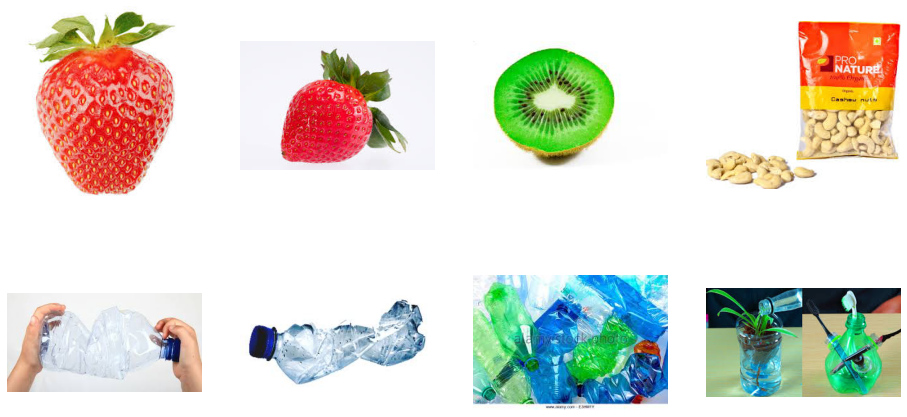

In [4]:
train_organic_fnames = os.listdir(train_organic_dir)
train_recycle_fnames = os.listdir(train_recycle_dir)
train_recycle_fnames.sort()

%matplotlib inline

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index += 4
next_organic_pix = [os.path.join(train_organic_dir, fname) 
                for fname in train_organic_fnames[pic_index-4:pic_index]]
next_recycle_pix = [os.path.join(train_recycle_dir, fname) 
                for fname in train_recycle_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_organic_pix + next_recycle_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  print(img.shape)

plt.show()

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,               # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        shuffle=True,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        shuffle=True,
        class_mode='binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [12]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)       

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=8,
      validation_data=validation_generator,
      verbose=1,
      shuffle=True)

Epoch 1/8
706/706 [==============================] - 392s 555ms/step - loss: 0.4689 - acc: 0.7976 - val_loss: 0.3197 - val_acc: 0.8858
Epoch 2/8
706/706 [==============================] - 233s 329ms/step - loss: 0.3962 - acc: 0.8345 - val_loss: 0.4207 - val_acc: 0.8181
Epoch 3/8
706/706 [==============================] - 247s 350ms/step - loss: 0.3768 - acc: 0.8471 - val_loss: 0.2954 - val_acc: 0.8826
Epoch 4/8
706/706 [==============================] - 228s 322ms/step - loss: 0.3557 - acc: 0.8559 - val_loss: 0.3000 - val_acc: 0.8957
Epoch 5/8
706/706 [==============================] - 228s 323ms/step - loss: 0.3459 - acc: 0.8609 - val_loss: 0.2785 - val_acc: 0.8874
Epoch 6/8
706/706 [==============================] - 227s 322ms/step - loss: 0.3410 - acc: 0.8661 - val_loss: 0.2598 - val_acc: 0.9045
Epoch 7/8
706/706 [==============================] - 228s 322ms/step - loss: 0.3346 - acc: 0.8675 - val_loss: 0.3552 - val_acc: 0.8687
Epoch 8/8
706/706 [==============================] - 17

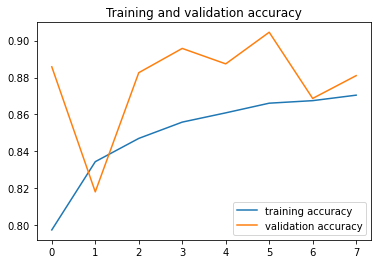

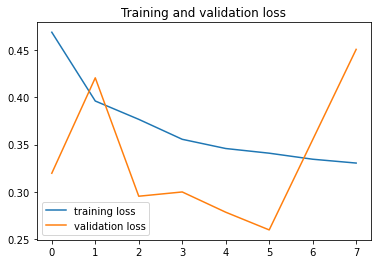

In [16]:
#@title Graphing accuracy and loss
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [17]:
# Flow validation images using val_datagen generator
val_visual = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        class_mode='binary',
        shuffle=True)

print(val_visual.class_indices)

Found 2513 images belonging to 2 classes.
{'O': 0, 'R': 1}


In [18]:
val_pred_prob = model.predict(val_visual)

In [20]:
len(val_pred_prob)

2513

In [21]:
# must get index array before getting predictions!
val_dir_indices = val_visual.index_array
val_true_labels = [0 if n < 1112 else 1 for n in val_dir_indices] # directory is sorted alphanumerically; 1st 1112: 'O', 2nd 1112: 'R'

# getting predictions in the form of probablities 
val_pred_prob = model.predict(val_visual)

# converting the probablities into binary values 
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: "+str(val_pred_labels))
print("Actual labels:     "+str(val_true_labels))

# determining the filepaths of misclassified waste
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_visual.index_array):
    misclassified_filepaths.append(val_visual.filepaths[dir_index])
    if pred_label != true_label:
        correctness.append('incorrect')
        num_misclasssified += 1
    else:
        correctness.append('correct')

print("# of total images: "+str(len(correctness)))
print("# of misclassified images: "+str(num_misclasssified))

Model predictions: [0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,

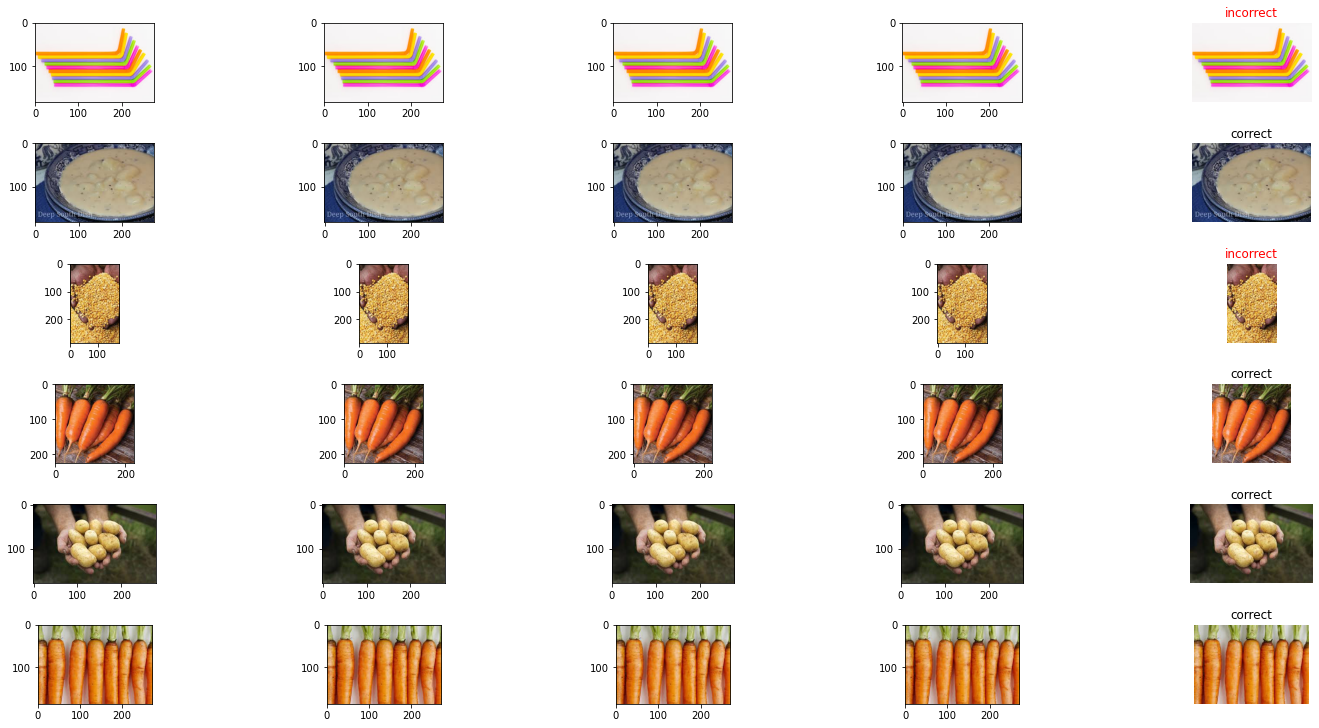

In [23]:
# obtain images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plot first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for r in range(6):
    for c in range(5):
        axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
        axarr[r,c].set_title(correctness[count])
    else:
        axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

In [24]:
loss, acc = model.evaluate(validation_generator, verbose=1)
print("Accuracy using evaluate: "+str(acc))
print("Loss using evaluate: "+str(loss))

79/79 [==============================] - 6s 76ms/step - loss: 0.4508 - acc: 0.8810
Accuracy using evaluate: 0.8810186982154846
Loss using evaluate: 0.45080357789993286


In [25]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_true_labels, val_pred_labels, labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_true_labels, val_pred_labels, labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[1098   14]
 [ 556  845]] 

Outcome values : 
 845 556 14 1098 

Classification report : 
               precision    recall  f1-score   support

           1       0.98      0.60      0.75      1401
           0       0.66      0.99      0.79      1112

    accuracy                           0.77      2513
   macro avg       0.82      0.80      0.77      2513
weighted avg       0.84      0.77      0.77      2513



### Tansfer Learning

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD

In [20]:
local_weights_file = r"C:\Users\Uddeshya Sahu\Desktop\RESUME\Projects_practice\Waste_classification\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [21]:
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [22]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [23]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [24]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True

# Configure the model
model = Model(pre_trained_model.input, x)

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [25]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [28]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/60
100/100 [==============================] - 78s 778ms/step - loss: 0.6678 - acc: 0.5897 - val_loss: 0.6501 - val_acc: 0.6256
Epoch 2/60
100/100 [==============================] - 78s 782ms/step - loss: 0.6443 - acc: 0.6305 - val_loss: 0.6328 - val_acc: 0.6631
Epoch 3/60
100/100 [==============================] - 77s 769ms/step - loss: 0.6327 - acc: 0.6523 - val_loss: 0.6225 - val_acc: 0.6787
Epoch 4/60
100/100 [==============================] - 82s 821ms/step - loss: 0.6152 - acc: 0.6816 - val_loss: 0.6048 - val_acc: 0.7113
Epoch 5/60
100/100 [==============================] - 85s 848ms/step - loss: 0.6043 - acc: 0.6938 - val_loss: 0.5867 - val_acc: 0.7575
Epoch 6/60
100/100 [==============================] - 80s 796ms/step - loss: 0.5867 - acc: 0.7253 - val_loss: 0.5763 - val_acc: 0.7456
Epoch 7/60
100/100 [==============================] - 79s 794ms/step - loss: 0.5715 - acc: 0.7331 - val_loss: 0.5628 - val_acc: 0.7581
Epoch 8/60
100/100 [==============================] - 8

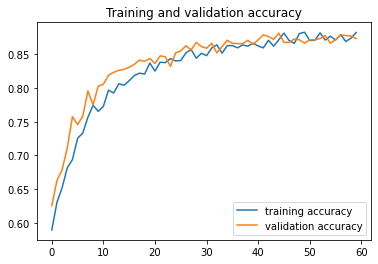

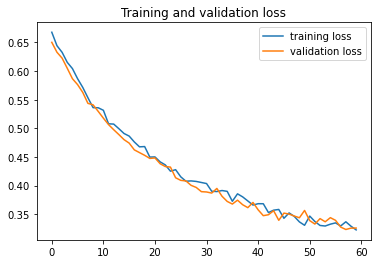

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [30]:
loss, acc = model.evaluate(validation_generator, verbose=1)
print("Accuracy using evaluate: "+str(acc))
print("Loss using evaluate: "+str(loss))

79/79 [==============================] - 22s 284ms/step - loss: 0.3274 - acc: 0.8750
Accuracy using evaluate: 0.8750497698783875
Loss using evaluate: 0.3273769021034241


In [33]:
# Flow validation images using val_datagen generator
val_visual = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        class_mode='binary',
        shuffle=True)

print(val_visual.class_indices)

Found 2513 images belonging to 2 classes.
{'O': 0, 'R': 1}


In [34]:
val_pred_prob = model.predict(val_visual)

In [36]:
# must get index array before getting predictions!
val_dir_indices = val_visual.index_array
val_true_labels = [0 if n < 1112 else 1 for n in val_dir_indices] # directory is sorted alphanumerically; 1st 1112: 'O', 2nd 1112: 'R'

# getting predictions in the form of probablities 
val_pred_prob = model.predict(val_visual)

# converting the probablities into binary values 
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: "+str(val_pred_labels))
print("Actual labels:     "+str(val_true_labels))

# determining the filepaths of misclassified waste
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_visual.index_array):
  misclassified_filepaths.append(val_visual.filepaths[dir_index])
  if pred_label != true_label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of total images: "+str(len(correctness)))
print("# of misclassified images: "+str(num_misclasssified))

Model predictions: [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,

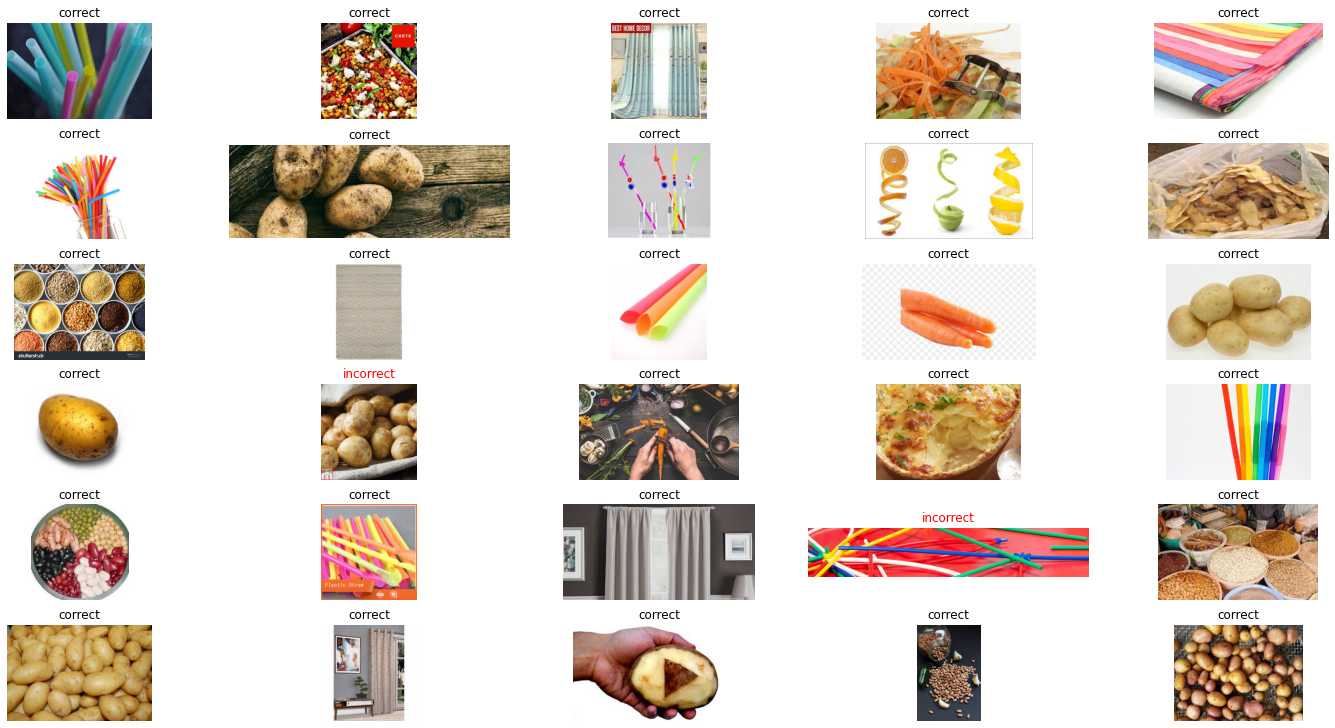

In [37]:
# obtaining the images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plots first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1 
plt.show()

In [38]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_true_labels, val_pred_labels, labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_true_labels, val_pred_labels, labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[1060   52]
 [ 507  894]] 

Outcome values : 
 894 507 52 1060 

Classification report : 
               precision    recall  f1-score   support

           1       0.95      0.64      0.76      1401
           0       0.68      0.95      0.79      1112

    accuracy                           0.78      2513
   macro avg       0.81      0.80      0.78      2513
weighted avg       0.83      0.78      0.77      2513

